In [1]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import SimpleITK as sitk
import numpy.random as random
import os
import math
import HeadCT_motion_correction_PAR.functions_collection as ff
import HeadCT_motion_correction_PAR.motion_simulator.transformation as transform
import nibabel as nb
import scipy
from scipy import interpolate

# our new B-spline model

In [3]:
def split_into_direction(amplitude,dim):
    while True:
        split = np.zeros(dim)
        for i in range(0,dim-1):
            split[i] = np.random.rand()
        split[-1] = 1 - np.sum(split)
        if split[-1] >= 0:
            break
    split = [math.sqrt(i * (amplitude ** 2)) for i in split]
    return np.asarray(split)

def direciton_vector(num, change_direction_limit):
    # e.g. if change_direction_limit = 2, the direction can only change every change_direction_limit points
    a = [-1 if int(np.random.uniform(-1,1) >= 0) == 0 else 1 for i in (0,1)][0]

    v = np.ones(num) * a
    same_direction_count = 0
    for i in range(1,num):
        same_direction_count += 1
        if same_direction_count <= change_direction_limit: # no change
            v[i] = v[i-1]
        if same_direction_count > change_direction_limit: # have the chance to change
            v[i] = [-1 if int(np.random.uniform(-1,1) >= 0) == 0 else 1 for i in (0,1)][0]
            if v[i] != v[i-1]:
                same_direction_count = 1
    return v

def euclidean_distance(u, v):
    return np.sqrt(np.sum(np.power(u - v, 2)))



In [348]:
# define the function for translation and rotation generation:
def motion_control_point_generation(dim, CP_num, amplitude_max, displacement_max, change_direction_limit):
    while True:
        t = np.zeros([CP_num,dim])
        # first randomly sample the displacmeent between two CPs  from [0,t_displacement_max]
        t_displacement= [np.random.rand() * displacement_max for i in range(0,CP_num - 1)]

        # get the direction vectors
        directions = np.ones([CP_num,dim])
        for i in range(0,dim):
            directions[:,i] = np.reshape(direciton_vector(CP_num, change_direction_limit), (CP_num,))

        # split displacement in x and y
        t_split = [split_into_direction(dis, dim) for dis in t_displacement]
        t_split = np.reshape(t_split, [CP_num-1,dim])
        t[1:,...] = t_split

        # assign direction to each control point
        t_direct = np.multiply(t, directions)

        # make amplitude vector
        t_amplitude = np.zeros([CP_num,dim])
        for i in range(0,dim):
            a = t_direct[:,i]
            a = [np.sum(a[0:i+1]) for i in range(0,CP_num)]
            t_amplitude[:,i] = a

        # check amplitude never exceed t_amplitude_max
        amplitude_euclidean = np.zeros(CP_num)
        for i in range(0,CP_num):
            amplitude_euclidean[i] = euclidean_distance(t_amplitude[i ,:] , [0,0])

        Assert = np.asarray([1 if np.round(amplitude_euclidean[i]) > amplitude_max  else 0 for i in range(0,amplitude_euclidean.shape[0])])


        if np.sum(Assert) == 0:
            # print('displacement: ',t_displacement)
            # print('directional displacement: ',t_direct)
            print('amplitude in x and z direction: ', t_amplitude)
            print('total amplitude: ',amplitude_euclidean,  '  max amplitude: ',np.max(amplitude_euclidean))
            return t_amplitude
            break

In [355]:
######### translation and rotation:
amplitude_max = 0
displacement_max = 0
CP_num = 5
change_direction_limit = 2

t_amplitude = motion_control_point_generation(2, CP_num, amplitude_max, displacement_max, change_direction_limit)
rz_amplitude = motion_control_point_generation(1, CP_num, amplitude_max, displacement_max, change_direction_limit)
rx_amplitude = motion_control_point_generation(1, CP_num, amplitude_max, displacement_max, change_direction_limit)

amplitude in x and z direction:  [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
total amplitude:  [0. 0. 0. 0. 0.]   max amplitude:  0.0
amplitude in x and z direction:  [[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
total amplitude:  [0. 0. 0. 0. 0.]   max amplitude:  0.0
amplitude in x and z direction:  [[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
total amplitude:  [0. 0. 0. 0. 0.]   max amplitude:  0.0


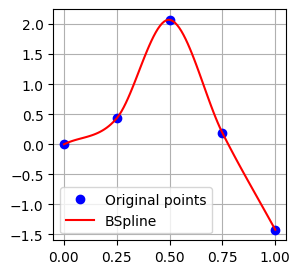

In [342]:
t = np.linspace(0, 1, 5)
x = t_amplitude[:,0] # x or y value in the same motion above
spline = transform.interp_func(t,x)
tt = np.linspace(np.min(t),np.max(t), 100)
plt.figure(figsize=(3,3))

plt.plot(t, x, 'bo', label='Original points')
plt.plot(tt, np.reshape(spline(tt),-1), 'r', label='BSpline')
plt.grid()
plt.legend(loc='best')
plt.show()

# B spline for 1D curve

In [91]:
# B spline for 1D curve
x = np.linspace(0, 500, 25)
y = np.array([0. , 0, -2, -2, -4]) # x or y value in the same motion above
   
y = np.array([0.   , -0.   , -0.   , 0,0, 
              0,  0,   0,   -2, -2, 
              -2, -2, -2, -2, -2,
              -2, -4, -4, -4, -4,
              -4, -4, -4, -4, -4 ])



[ 0.  0. -2. -4. -4.]


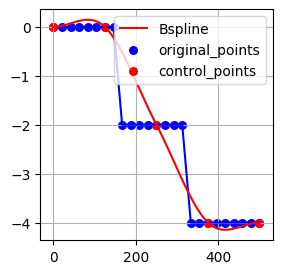

In [92]:
# t, c, k = interpolate.splrep(x, y, s=0, k=1)

N = 5
xmin, xmax = x.min(), x.max()
xc = np.linspace(xmin, xmax, N)

yc = transform.spline_motion_functions.interp(x, y, xc)
print(yc)

plt.figure(figsize=(3,3))
plt.scatter(x, y, s=30, color='blue', marker='o', label = 'original_points')
plt.plot(x, y, 'b-')

plt.scatter(xc, yc, s=30, color='red', marker='o', label = 'control_points')
xs = np.linspace(xmin, xmax, 100)
ys = transform.spline_motion_functions.interp(xc, yc, xs)
plt.plot(xs, ys, 'r-', label = 'Bspline')


plt.grid()
plt.legend(loc='best')
plt.show()
    

# Our spline motion model

In [4]:
limit_dif = 5; # 4mm
limit_amp = 10
limit_change_dir = 2 # you can change direciton every two CP
CP_num = 5
amplitude_x, amplitude_y = transform.make_spline_CP_2D_translation(limit_amp, limit_dif, limit_change_dir, CP_num)

amplitude_r = transform.make_spline_CP_rotation(limit_amp, limit_dif, limit_change_dir, CP_num)

print(amplitude_x, amplitude_y, amplitude_r)

[0, -0.2929800947940679, -2.8634309947583105, -1.1130656196102484, 0.5379627238753875] [0, 0.5344481869324529, 2.8493746740446473, 5.37424699375589, 4.309461298230239] [0, -0.801717063877157, -2.3518034146263633, -6.169429167326221, -6.909436095724626]


In [5]:
amplitude_x = np.array([0, -1.3, -2.5, -1, -0.1])
amplitude_y = np.array([0, -1.6, -3.3, -6, -6.7])
amplitude_r = np.array([0, -2, -5.7, -5.6, -4.5])

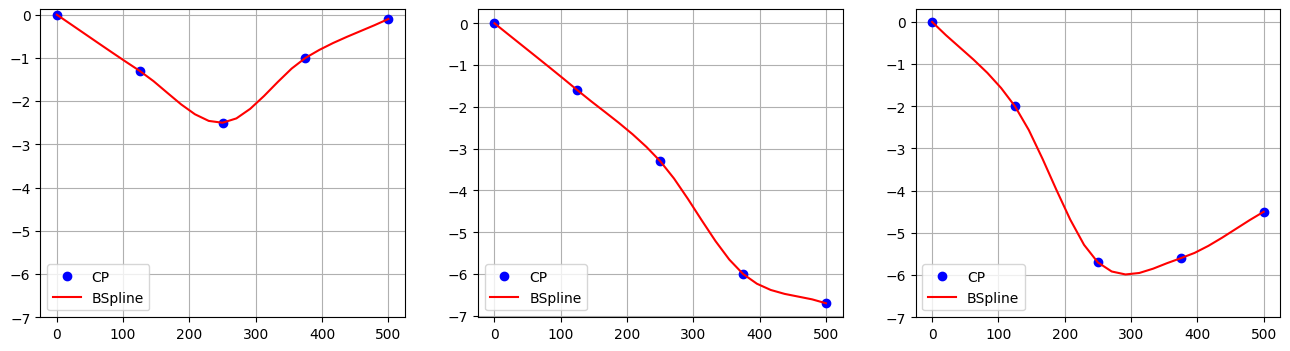

In [6]:
t = np.linspace(0, 500, CP_num, endpoint=True) # gantry rotation time

x = np.asarray(amplitude_x).reshape(-1)
y = np.asarray(amplitude_y).reshape(-1)
r = np.asarray(amplitude_r).reshape(-1)

spline_x = transform.interp_func(t,x)
spline_y = transform.interp_func(t,y)
spline_r = transform.interp_func(t,r)

N = 25
tmin, tmax = t.min(), t.max()
tt = np.linspace(tmin, tmax, N)


plt.figure(figsize = (16,4))
plt.subplot(131)
plt.plot(t, x, 'bo', label='CP')
plt.plot(tt, spline_x(tt).reshape(-1), 'r', label='BSpline')
plt.yticks(np.arange(0,-8,step = -1))
plt.grid()
plt.legend(loc='lower left')

plt.subplot(132)
plt.plot(t, y, 'bo', label='CP')
plt.plot(tt, spline_y(tt).reshape(-1), 'r', label='BSpline')
plt.yticks(np.arange(0,-8,step = -1))
plt.grid()
plt.legend(loc='lower left')


plt.subplot(133)
plt.plot(t, r, 'bo', label='CP')
plt.plot(tt, spline_r(tt).reshape(-1), 'r', label='BSpline')
plt.yticks(np.arange(0,-8,step = -1))
plt.grid()
plt.legend(loc='lower left')


gt vs. prediction

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

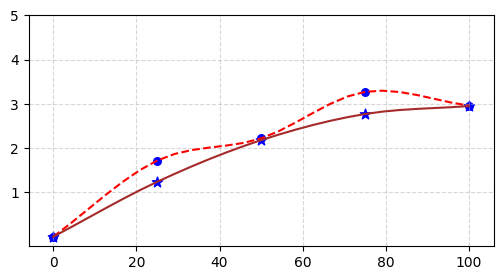

In [13]:
gt = np.array([0, 0, 3, 0, 0])
pred = np.array([0,1.24, 2.18, 2.77, 2.95])

t = np.linspace(0, 100, 5, endpoint=True) # gantry rotation time

x = np.asarray(gt).reshape(-1)
y = np.asarray(pred).reshape(-1)

spline_x = transform.interp_func(t,x)
spline_y = transform.interp_func(t,y)


N = 25
tmin, tmax = t.min(), t.max()
tt = np.linspace(tmin, tmax, N)

fig = plt.figure(figsize = (6,3))
plt.scatter(t, x, c = 'blue', marker = 'o', s = 30)
plt.plot(tt, spline_x(tt).reshape(-1), 'r--', label='B-spline fit', linewidth = 10 )

# plt.scatter(t, y, c = 'blue',marker = '*', s = 60)
# plt.plot(tt, spline_y(tt).reshape(-1), 'brown', label='B-spline fit')

plt.yticks(np.arange(1,5.1,step = 1))
plt.xticks(np.arange(0,101,step = 20))
# plt.ylabel("translation (mm)", fontsize = 13)
# plt.xlabel("% of gantry rotation time", fontsize = 12)
plt.grid(True, linestyle='dashed', alpha=0.5)

save_path = '/mnt/mount_zc_NAS/motion_correction/pictures/Fully3D/splines'
plt.savefig(os.path.join(save_path, 'top_results.eps'), transparent = True)